In [1]:
from pmotifs.analysis_utilities.loading import Result
from pmotifs.config import config

GRAPHLET_SIZE = 3

r = Result.load_result(
    config.DATASET_DIRECTORY /  "yeastInter_st.txt",
    config.EXPERIMENT_OUT / "yeastInter_st",
    GRAPHLET_SIZE,
)

g = r.pmotif_graph
df = r.positional_metric_df

Loading graph modules: 100%|████████████████| 27/27 [00:00<00:00, 243017.61it/s]


In [2]:
from pmotifs.analysis_utilities.metric_consolidation import metrics

potential_metrics = metrics.keys()
potential_metrics

dict_keys(['max normalized anchor hop distance', 'min normalized anchor hop distance', 'mean normalized anchor hop distance', 'graph module participation ratio', 'degree'])

In [3]:
graphlet_classes = set(df["graphlet_class"])
graphlet_classes

{'011 100 100', '011 101 110'}

In [4]:
METRIC_NAME = "graph module participation ratio"

assert METRIC_NAME in potential_metrics

In [5]:
from typing import Union

from pmotifs.GraphletPositionalMetrics import GraphletPositionalMetrics


def get_positional_metric(result: Result) -> Union[int, float]:
    """A wrapper to consolidate metrics"""
    return metrics[METRIC_NAME](result)

# Analysis

In [6]:
df[METRIC_NAME] = get_positional_metric(r)

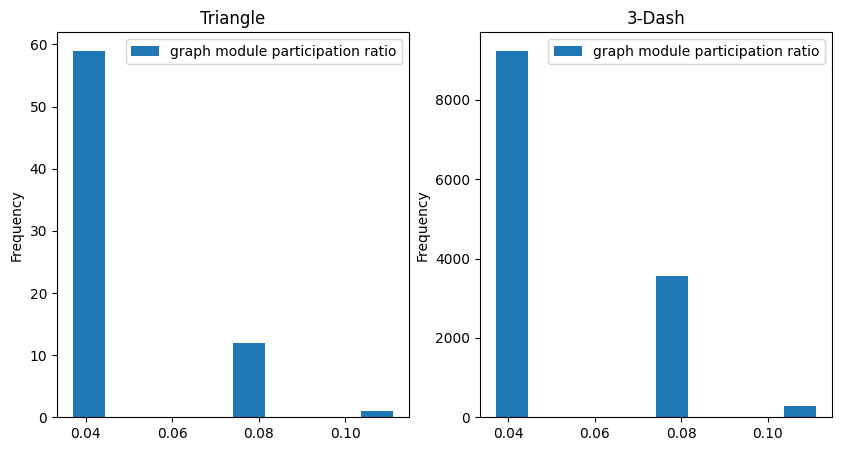

In [7]:
import matplotlib.pyplot as plt

from pmotifs.graphlet_representation import graphlet_class_to_name


fig, axes = plt.subplots(1, len(graphlet_classes), figsize=(len(graphlet_classes) * 5, 5))

for i, graphlet_class in enumerate(graphlet_classes):
    
    ax = axes[i]
    df[df["graphlet_class"] == graphlet_class][METRIC_NAME].plot.hist(
        ax=ax, label=METRIC_NAME,
    )
    ax.set_title(graphlet_class_to_name(graphlet_class))
    ax.legend()

Text(0.5, 1.0, 'graph module participation ratio Histogram of all 3-Graphlets')

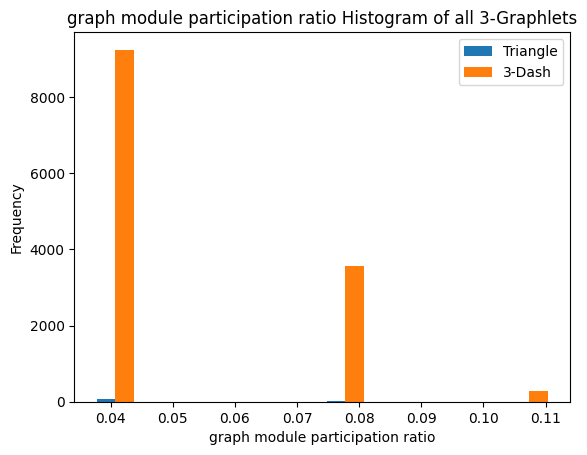

In [8]:
import matplotlib.pyplot as plt

from pmotifs.graphlet_representation import graphlet_class_to_name


fig, ax = plt.subplots(1, 1)

x = [
    df[df["graphlet_class"] == graphlet_class][METRIC_NAME]
    for graphlet_class in graphlet_classes
]

ax.hist(x, label=[graphlet_class_to_name(graphlet_class) for graphlet_class in graphlet_classes])
ax.legend()
ax.set_xlabel(METRIC_NAME)
ax.set_ylabel("Frequency")
ax.set_title(f"{METRIC_NAME} Histogram of all {GRAPHLET_SIZE}-Graphlets")

In [9]:
from scipy.stats import mannwhitneyu
import pandas as pd

mannwhitneyu_results = pd.DataFrame(
    index=list(graphlet_classes),
    columns=list(graphlet_classes),
)

for graphlet_class_x in graphlet_classes:
    x = df[df["graphlet_class"] == graphlet_class_x][METRIC_NAME]
    for graphlet_class_y in graphlet_classes:
        y = df[df["graphlet_class"] == graphlet_class_y][METRIC_NAME]
        stat = mannwhitneyu(x, y)
        mannwhitneyu_results[graphlet_class_x][graphlet_class_y] = {
            "statistic": stat.statistic,
            "pvalue": stat.pvalue,
        }

rename_lookup = {
    graphlet_class: graphlet_class_to_name(graphlet_class)
    for graphlet_class in graphlet_classes
}
mannwhitneyu_results.rename(
    index=rename_lookup,
    columns=rename_lookup,
    inplace=True,
)
mannwhitneyu_results.style.set_caption("Mann-Whitney-U-test ")


,Triangle,3-Dash
Triangle,"{'statistic': 2592.0, 'pvalue': 1.0}","{'statistic': 523776.5, 'pvalue': 0.03717503615785966}"
3-Dash,"{'statistic': 417839.5, 'pvalue': 0.03717503615785966}","{'statistic': 85517042.0, 'pvalue': 1.0}"
